<a href="https://colab.research.google.com/github/gisalgs/notebooks/blob/main/point-in-polygon-3.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Point-in-polygon: the even-odd algorithm

Point-in-polygon is a crucial operation when we handle spatial data. For example, if we click on a polygon in QGIS, we want to quickly pull out the data about this polygon (instead of waiting for a while before the data shows up). There are many ways to determine whether a point is in a polygon and we introduce the **even-odd algorithm** here. To determine if a point (such as one of the dots in following figure) is in a polygon, we first draw a half line that starts from the point and points to the right of the point. If the half line intersects with the polygon in an odd number of times, then we say the point is in the polygon. Otherwise the point is outside the polygon.

<img width=350px src="https://github.com/gisalgs/notebooks/blob/main/figures/pip-1.png?raw=1"/>

This seemingly simple algorithm, however, has many special cases that are tedious and must be addressed. For example, the half line *a* in the figure has a part of the polygon boundary on it and we will have to decide how many times the half lines intersects the polygon. Also, when a half line (e.g., *b* and *c*) goes through a vertex of the polygon, how many times should we count the intersection?

The next consideration is the calculation of intersection points. Computing the physical intersection point, if any, is an expensive process -- it takes some time to do and it takes a lot of times if we have a lot of intersection points to compute. To understand this, we should remember the so called polygon in GIS has many line segments and we will have to test whether each of the line segments intersects with the half line. That sounds a lot. But the good news is: we don't have to get the physical intersection point for most of the cases. For many cases, we just need to make a quick decision whether the half line intersects with the boundary. We can illustrate this using the following figure.

<img width=350px src="https://github.com/gisalgs/notebooks/blob/main/figures/pip-2.png?raw=1"/>

In the above figure, it is clear that the half line (the one starts at point *A*) is not going to intersect with line segments *a*, *d*, and *e*. Line segment *c* crosses the half line, but we don't need to compute the intersection point --- we know for fact they will intersect because the two end points of *c* are on the different sides of the half line, and are to the right of point *A*. Taking out these cases, we only have one case left: line segments like *b* or *b'* where the two end points are on both sizes of the half line but one of the end point is to the left of point *A*.

Then we need to consider a few **special cases**, when the point (dark dot below) is on one of the two ends of the line segment, or on a horizontal or vertical line.

<img width=450px src="https://github.com/gisalgs/notebooks/blob/main/figures/point-in-polygon-special-cases.png?raw=1"/>

In this tutorial, we are not going to discuss the details of calculating intersection of two line segments. Please refer to sections 2.5 and 2.6 in the *GIS Algorithms* book for those details.

The even-odd algorithm for determining if a point is in a polygon is implemented as function `pip_cross` in [point_in_polygon.py](https://github.com/gisalgs/geom/blob/master/point_in_polygon.py). This code was adopted from the C program in Graphics Gems IV by Haines (1994). The code will raise an error if the polygon is not closed.

To fully understand the code, we should try one of the half-lines and see whether the function returns the right result. Let's try the half-line **a**. We also assume the right-most point is the first point of the polygon and the sequence of points goes counterclockwise. We are going to check the algorithm for each line segment. The order the line segments are marked in the following figure.

<img width=350px src="https://github.com/gisalgs/notebooks/blob/main/figures/pip-1x.jpeg?raw=1"/>

Below, the first number in each line refers to the line segment. When we refer to the line numbers of the `pip_cross` function, the numbers are shown in [the github Python file](https://github.com/gisalgs/geom/blob/master/point_in_polygon.py).

1 - yside1 = True, yside2 = True. Condition on line 65 is False. Next point.  
2 - yside1 = True, yside2 = True.  
3 - yside1 = True, yside2 = True.  
4 - yside1 = True, yside2 = True.  
5 - yside1 = True, yside2 = False, xside1 = xside2 = True. Condition on line 65 is True, line 66 is True, line 67 is True. cross_count = 1, is_point_inside = True  
6 - similar 5. cross_count = 2, is_point_inside = False  
7 - similar 6. cross_count = 3, is_point_inside = True    
8 - similar 7. cross_count = 4, is_point_inside = False  
9 - similar 8. cross_count = 5, is_point_inside = True    
10 - similar 9. cross_count = 6, is_point_inside = False  
11 - similar 10. cross_count = 7, is_point_inside = True    
12 - similar 11. cross_count = 8, is_point_inside = False

So the final result is `(False, 8)`, meaning there are 8 intersections and the point forming the half line a is not in the polygon.

If we consider half-line **b**, here is what we have:

1 - yside1 = yside2 = True. Condition on line 65 is False. Next.  
2...7 - Next  
8 - yside1 = False, yside2 = True, xside1 = False, xside2 = True. Condition on line 65 is True, on line 70 is True. Calculate m and we have m > x because intersection is on the right side of the point. line 76 is True. cross_count = 1, is_point_inside = True  
9 - yside1 = False, yside2 = True, xside1 = True, xside2 = True. Condition on line 65 is True, on line 66 is True, cross_count = 2, is_point_inside = False  
10 - similar to 9. cross_count = 3, is_point_inside = True  
11 - similar to 10. cross_count = 4, is_point_inside = False  
12 - similar to 11. cross_count = 5, is_point_inside = True  

This time it is a little more subtle because the half-line "crosses" 5 line segments even though it only touches one of the end points, and some of the end points are double counted. So we should know that the count may not make sense, but the detection of whether the point is in or not should always be right. Of course we decide that a point on the boundary will be considered as in the polygon, which may not be desired in some cases.

In [11]:
!git clone https://github.com/gisalgs/geom.git

fatal: destination path 'geom' already exists and is not an empty directory.


We now import the code  and test the algorithm using some artificial data below.

In [10]:
from geom.point import *
from geom.point_in_polygon import *

points1 = [ [0,10], [5,0], [10,10], [15,0], [20,10],
           [25,0], [30,20], [40,20], [45,0], [60, 50], [50,50],
           [40,40], [30,50], [25,20], [20,50], [15,10],
           [10,50], [8, 8], [4,50], [0,10] ]
polygon1 = [Point(p[0], p[1]) for p in points1]

p1 = Point(10, 30)
p2 = Point(10, 20)
p3 = Point(20, 40)
p4 = Point(5, 40)
p5 = Point(35, 20)
p6 = Point(55, 50)

for p in [p1, p2, p3, p4, p5, p6]:
    print(f'Point {p} is {"IN" if pip_cross(p, polygon1)[0] is True else "OUT"}')

Point (10, 30) is IN
Point (10, 20) is IN
Point (20, 40) is IN
Point (5, 40) is OUT
Point (35, 20) is IN
Point (55, 50) is IN


Below we will show a visual proof of the above results. Before we plot the figure, we need to import matplotlib first:

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

We also need a little function as a helper to translate True and False values to 1 and 0, respectively.

In [13]:
# use this function to get 1 when result is True, 0 otherwise
def in_or_out(pip_result):
    if pip_result:
        return 1
    return 0

We will use the above little function to automatically assign two colors: if the point is in then we make it blue, otherwise red (see the line starts with `colors` below.

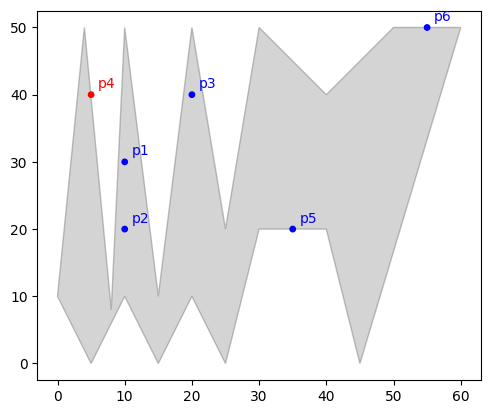

In [14]:
ax = plt.gca()
line1 = [ [p.x, p.y] for p in polygon1 ]
pg1 = plt.Polygon(line1, closed=True, fill=True,
                  facecolor='#AAAAAA', edgecolor='grey', alpha=0.5)
ax.add_patch(pg1)

pts = [p1, p2, p3, p4, p5, p6]

results = [in_or_out(pip_cross(p, polygon1)[0]) for p in pts] # do this without using in_or_out?

colors = [['red', 'blue'][i] for i in results]

l2 = plt.scatter([p.x for p in pts], [p.y for p in pts], color=colors, s=15)
labels = ['p%s'%(i+1) for i in range(len(pts))]
for i, p in enumerate(pts):
    plt.text(p.x+1, p.y+1, labels[i], color=colors[i])

ax.set_aspect(1)
plt.show()

Note the above code assumes the polygon is properly closed. If we cannot guarantee, the actual code will be more tedious because we will have to use the try statement:

In [15]:
points2 = [ [0,10], [5,0], [10,10], [15,0], [20,10] ]
polygon2 = [ [ Point(p[0], p[1]) for p in points2 ] ]

try:
    print(f'Point {p1} is {"IN" if pip_cross2(p1, polygon2)[0] is True else "OUT"}')
except Exception as err:
    print(err)

Polygon not closed


## Case study: Polygon area using Monte Carlo simulation

We are going to use what we have learned so far to do an experiment.

First, let's make a triangle that has a minimal bounding box (envelope) defined as `[0, 10, 0, 10]`, which are the lower bound and upper bound of x, and that of y, respectively.

In [16]:
# TODO: create a triangle here. It will be a list of four Point objects, with the first and last being the same point.
#       make sure its *minimum bounding box is [0, 10, 0, 10]
#
coords_triangle = [[1, 1], [9, 1], [5, 9], [1, 1]]
triangle_points = [Point(x, y) for x, y in coords_triangle]

coords_box =[[0, 0], [10, 0], [10, 10], [0, 10], [0, 0]]
box_points = [Point(x, y) for x, y in coords_box]
triangle_outline = [[pt.x, pt.y] for pt in triangle_points]
box_outline = [[pt.x, pt.y] for pt in box_points]

triangle_shape = plt.Polygon(triangle_outline, closed=True, fill=True, facecolor='#FFAAFF', edgecolor='blue', alpha=0.6)
box_shape = plt.Polygon(box_outline, closed=True, fill=False, edgecolor='red', alpha=0.7)

Make sure we can draw the triangle, along with its bounding box.

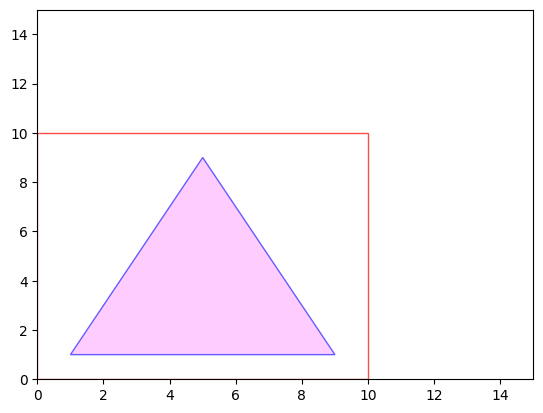

In [18]:
# TODO: Draw triangle and bounding box here
#
fig, ax = plt.subplots()
ax.add_patch(triangle_shape)
ax.add_patch(box_shape)
ax.set_xlim(0,15)
ax.set_ylim(0,15)
plt.show()


Now we randomly generate 100 points.

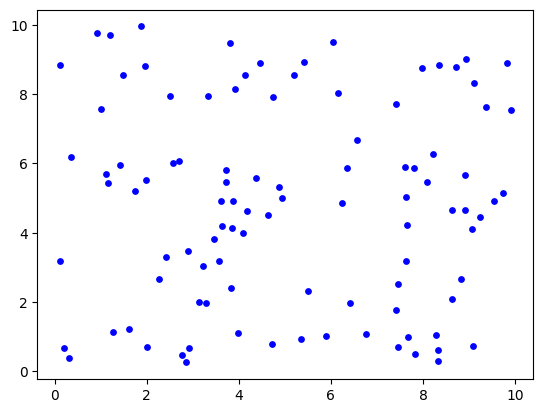

In [19]:
# TODO: generate 100 random points with the bounding box
import random
ts = plt.subplots()
box_outline = [[pt.x, pt.y] for pt in box_points]


box_shape = plt.Polygon(box_outline, closed=True, fill=False, edgecolor='red', alpha=0.7)
ax.add_patch(box_shape)


rand = [[ random.uniform(0.0,10.0), random.uniform(0.0,10.0)] for t in range(100)]
rand_p = [Point(x, y) for x, y in rand]
plt.scatter([p.x for p in rand_p], [p.y for p in rand_p], color='blue', s=15)
ax.set_xlim(0,15)
ax.set_ylim(0,15)
plt.show()


Count how many points are within the triangle.

In [23]:
# TODO: count the number of points in the triangle
def counter ( rand_p, triangle_points):
  count = 0
  for t in rand_p:
    if pip_cross(t, triangle_points)[0] == True:
      count += 1
  return count

count = counter(rand_p, triangle_points)
print(count)

36


Calculate the size of the triangle. Use the proportion of the points within the triangle and the size of the bounding box.

In [24]:
# TODO: compute the size of the triangle
def tri_s (bound_b, num_p, rand_p, triangle_points):
  return counter(rand_p, triangle_points) / num_p * bound_b


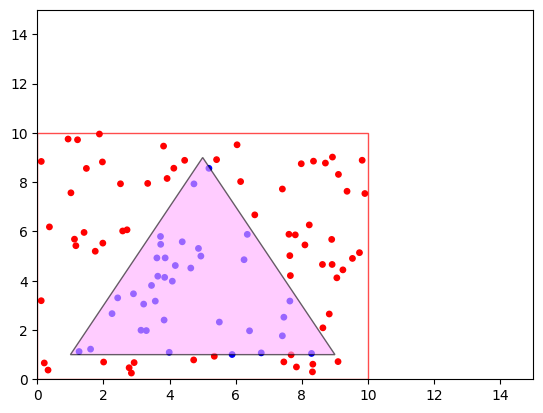

In [25]:
# TODO: draw the triangle, bounding box, and points
#       points in the triangle are rendered blue
#       points outside are red

ax = plt.gca()
triangle_outline = [[pt.x, pt.y] for pt in triangle_points]
box_outline = [[pt.x, pt.y] for pt in box_points]
tri = plt.Polygon(triangle_outline, closed=True, fill=True, facecolor='#FFAAFF', edgecolor='black', alpha=0.6)
box = plt.Polygon(box_outline, closed=True, fill=False, edgecolor='red', alpha=0.7)

output = [in_or_out(pip_cross(p, triangle_points)[0]) for p in rand_p]
colors = [['red', 'blue'][i] for i in output]

plt.scatter([p.x for p in rand_p], [p.y for p in rand_p], color=colors, s=15)
ax.add_patch(tri)
ax.add_patch(box)
ax.set_xlim(0,15)
ax.set_ylim(0,15)
plt.show()



At this point, we should get a value that is supposed to be the size of the triangle. But this is just one estimation. If we do this again, we would get a different answer. If we repeat this process 100 times, each time we have an estimate of the size of the triangle and we can plot a histogram that should tell us a lot about the size of the triangle. We can calculate the mean of all the estimated sizes. We can also draw the points with the triangle to get some kind of visual proof. This experiment can go on (for example, we can use 1000 points instead of 100). This is generally what we mean by a Monte Carlo simulation.

In [26]:
# TODO: use a loop of 100 iterations to repeat the above process of
#       generating 100 random points and estimate the triangle size.
#       In every iteration, we will an estimate of the area.
#       We put all the estimate in a list called areas

areas = []
bound_b = 100
num_p = 100
for t in range (100):
  rand = [[ random.uniform(0.0,10.0), random.uniform(0.0,10.0)] for t in range(num_p)]
  rand_p = [Point(x, y) for x, y in rand]
  areas.append(tri_s(bound_b, num_p, rand_p, triangle_points))




When all is done (100 iterations and 100 areas), the list `areas` will have 100 values and we draw a histogram using the following code.

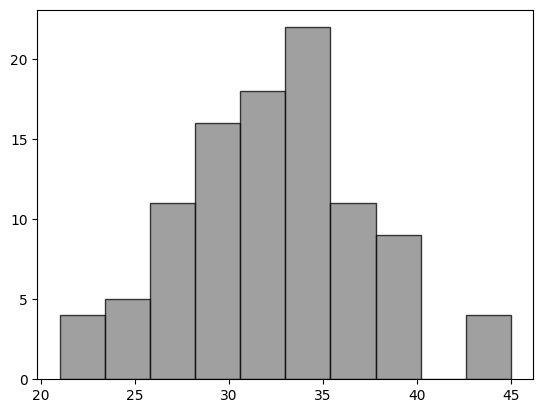

In [27]:
ax = plt.gca()
ax.hist(areas, 10, facecolor='grey', edgecolor='black', alpha=0.75)
plt.show()